### In this section, we explore the sample on which we will run the scarlet model!!

Some things I want to do with the eventual final scarlet test:

1) build scarlet models for nearby low-mass dwarf galaxies. Nearby as most likely to be shredded, and low mass so angular size is smaller and thus less expensive

2) Want to make a plot comparing the scarlet mags with aperture photo mags

3) When do we need the LSB wavelet component included or not?

4) Need to visually inspect ones to avoid repetition

3) For the most irregular ones, make a scarlet model highlighting how future directions could be useful here??

In constructing the scarlet model, need to thing about how to thing about masking other sources outside main island .. and how large to choose the cutout size 

In [1]:
import os
import sys

import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, print_radecs, sdss_rgb

In [2]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

def filter_close_sources(ra, dec, radius_arcsec=30):
    """
    Remove sources that lie within <radius_arcsec of another source.
    Keeps the first instance encountered.

    ra, dec : arrays in degrees
    returns : indices of the sources to keep
    """
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    keep = []
    mask = np.ones(len(coords), dtype=bool)

    for i in range(len(coords)):
        if not mask[i]:
            continue  # this one was already excluded
        keep.append(i)
        # mark all others within the radius as excluded
        sep = coords[i].separation(coords)
        mask[sep < (radius_arcsec*u.arcsec)] = False

    return np.array(keep)



def basic_filter_scarlet(data):
    data_scarlet = data[(data["Z"] < 0.01) & (data["LOGM_SAGA_APERTURE_COG"] < 8) & (data["LOGM_SAGA_APERTURE_COG"] > 6) 
                        & (data["MASKBITS"]==0) & (data["SGA_D26_NORM_DIST"] > 2) & (data["is_south"] == 1)  ]

    return data_scarlet
    

def get_entire_scarlet():

    data_bgsb = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
    data_bgsf = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
    data_lowz = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
    data_elg = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")
    
    data_bgsb = basic_filter_scarlet(data_bgsb)
    data_bgsf = basic_filter_scarlet(data_bgsf)
    data_lowz = basic_filter_scarlet(data_lowz)
    data_elg = basic_filter_scarlet(data_elg)

    print(len(data_bgsb), len(data_bgsf), len(data_lowz), len(data_elg))

    data_all = vstack([data_bgsb, data_bgsf, data_lowz, data_elg])

    print(len(data_all))
    
    # example usage:
    keep_indices = filter_close_sources( data_all["RA"].data, data_all["DEC"].data, radius_arcsec = 60 )

    data_all = data_all[keep_indices]

    print(len(data_all))

    return data_all

    


In [3]:
data_scarlet_f = get_entire_scarlet()

173 3 0 22
198
166


Making summary panel plots:

grz image, tractor reconstruction, scarlet reconstruction, scarlet residuals 

In [4]:
from matplotlib.patheffects import withStroke
import requests
import os
import sys
import numpy as np
from astropy.io import fits
from astropy.table import Table, vstack
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.patches import Circle


session = requests.Session()

def get_tractor_model(ra,dec,size=350,path=None):
    '''
    We extract the model image from Tractor using hte url method
    '''
    if os.path.exists(path):
        pass
    else:
        url_prefix = 'https://www.legacysurvey.org/viewer/'
    
        url = url_prefix + f'cutout.fits?ra={ra}&dec={dec}&size=%s&'%size
        
        url += 'layer=ls-dr9-model&pixscale=0.262&bands=grz'
        resp = session.get(url)
        with open(path, "wb") as f:
            f.write(resp.content)
            
    return      

def get_tractor_model_resid(ra,dec,size=350,path=None):
    '''
    We extract the model image from Tractor using hte url method
    '''

    if os.path.exists(path):
        pass
    else:
        url_prefix = 'https://www.legacysurvey.org/viewer/'
    
        url = url_prefix + f'cutout.fits?ra={ra}&dec={dec}&size=%s&'%size
        
        url += 'layer=ls-dr9-resid&pixscale=0.262&bands=grz'
        resp = session.get(url)
        with open(path, "wb") as f:
            f.write(resp.content)
            
    return  


In [31]:

def plot(index, data_scarlet):

    ra = data_scarlet["RA"][index]
    dec = data_scarlet["DEC"][index]
    
    file_path = data_scarlet["FILE_PATH"][index]
    img_path = data_scarlet["IMAGE_PATH"][index]
    try:
        img_data_total = fits.open(img_path)[0].data
        
        print(file_path)
        
        scar_mags = np.load( file_path + "/scarlet_mags.npy")
    
        #get the dwarf only model with scarlet
        scarlet_total_model = np.load(file_path + "/total_model_rgb.npy")
        scarlet_model_rgb = np.load(file_path + "/dwarf_model_rgb.npy")
        scarlet_resid_rgb = np.load(file_path + "/model_residual_rgb.npy")
        bounding_box_coords = np.load(file_path + "/bounding_box_coords.npy")
        
        ##### PREPARING THE ACTUAL IMAGES!
        img_data = img_data_total[:, bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
        img_rgb = sdss_rgb([img_data[0],img_data[1],img_data[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)
    
        ## load the dwarf only model with tractor!!
        
        tractor_bkg_model = np.load(file_path + "/tractor_background_model.npy")
        tractor_blend_model = np.load(file_path + "/tractor_blend_remove_model.npy")
        
        tractor_dwarf_model = img_data_total - tractor_bkg_model - tractor_blend_model
        tractor_dwarf_model = tractor_dwarf_model[ :, bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
        #apply the aperture mask
        aper_cog_mask = np.load(file_path + "/final_mask_cog.npy")
        aper_cog_mask = aper_cog_mask[bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
        
        tractor_dwarf_model[:, aper_cog_mask] = 0
        tractor_dwarf_model_rgb = sdss_rgb([tractor_dwarf_model[0],tractor_dwarf_model[1],tractor_dwarf_model[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)
    
        desi_fiber_pos = np.load(file_path + "/fiber_pix_pos_org.npy")
        #we need to update this 
    
        desi_fiber_pos = desi_fiber_pos - np.array([bounding_box_coords[0] , bounding_box_coords[2]] )
        
        fig,ax = make_subplots(ncol = 1, nrow = 4, return_fig = True,row_spacing = 0.)

        ax[3].set_title(index,fontsize = 15)
        ax[3].imshow(img_rgb,origin="lower",zorder = 0)
    
        radius_in_pixels = (1.5/2)/0.262 #radius of DESI fiber diameter
        circle = patches.Circle( (desi_fiber_pos[1], desi_fiber_pos[0]),radius_in_pixels, color='limegreen', fill=False, linewidth=1.5,ls ="--")
        ax[3].add_patch(circle)
        
        fs = 15
        
        ax[0].set_ylabel(r"Scarlet Residuals",fontsize = fs)
        ax[1].set_ylabel(r"Scarlet Reconstruction",fontsize = fs)
        ax[2].set_ylabel(r"Original Reconstruction",fontsize = fs)
        ax[3].set_ylabel(r"$grz$ image",fontsize = fs)
            
        ax[3].text(0.5, 0.95,f"({ra:.3f}, {dec:.3f})",color = "white",fontsize = 15,
                     transform=ax[3].transAxes, ha = "center", verticalalignment='top')
        
    
        fst = 15
        ax[2].text(
        0.5, 0.925,
        rf"$\mathrm{{mag_{{aper}}}}$: ({data_scarlet['MAG_G_APERTURE_COG'][index]:.1f}, "
        rf"{data_scarlet['MAG_R_APERTURE_COG'][index]:.1f}, "
        rf"{data_scarlet['MAG_Z_APERTURE_COG'][index]:.1f})",
        ha="center", va="center",
        fontsize=fst, color="white",
        transform=ax[2].transAxes)
    
        ax[1].text(
        0.5, 0.925,
        rf"$\mathrm{{mag_{{scarlet}}}}$: ({scar_mags[0]:.1f}, "
        rf"{scar_mags[1]:.1f}, "
        rf"{scar_mags[2]:.1f})",
        ha="center", va="center",
        fontsize=fst, color="white",
        transform=ax[1].transAxes
    )
    
        ax[2].imshow(tractor_dwarf_model_rgb,origin="lower")    
        ax[1].imshow(scarlet_model_rgb,origin="lower")
        ax[0].imshow(scarlet_resid_rgb,origin="lower")
    
    
        org_size = np.shape(img_data)[1]
    
        for axi in ax:
            axi.set_xticks([])
            axi.set_yticks([])
    
    
            bar_frac = 15/(org_size * 0.262)
    
            x_start_frac = 0.07  # 7% from left
            y_start_frac = 0.07  # 7% from bottom
            
            # Draw the scale bar in axes coordinates
            axi.plot([x_start_frac, x_start_frac + bar_frac],
                    [y_start_frac, y_start_frac],
                    color='white', lw=1, transform=axi.transAxes)    
        
        
    
        plt.savefig(f"/pscratch/sd/v/virajvm/trash/scarlet_comp_plots/scarlet_tractor_compare_{index}.png",bbox_inches="tight",dpi=150)
        plt.close()

    except:
        print(f"Error in {index}: {file_path}")


In [32]:
## NEED TO UPDATE THE GRZ COLOR LSB CUTOFF, r-z should be 0.2?
## and we do aperture photometry in a larger aperture as sometimes there can be residual
## add titles and photometry info with tgids, stellar mass, redshift etc.
## we do not do a separate model for the special ones now, we move directly to SGA and NSA comp!

## loop through and collect all the scarlet mags!

In [33]:
data_scarlet_f[163]["FILE_PATH"]

'/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-250p005-260p010/2545p065/ELG_tgid_39627945790150527'

In [38]:
## identify the list of objects that we will show in the plot



In [39]:
for index in range(len(data_scarlet_f)):
    plot(index, data_scarlet_f)

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-050m020-060m015/0569m157/BGS_BRIGHT_tgid_39627409678405366
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-060m015-070m010/0659m107/BGS_BRIGHT_tgid_39627527471238320
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-130m010-140m005/1379m085/BGS_BRIGHT_tgid_39627582294986978
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-150m010-160m005/1500m082/BGS_BRIGHT_tgid_39627588477388423
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-190m010-200m005/1967m080/BGS_BRIGHT_tgid_39627595238610026
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-130m010-140m005/1332m077/BGS_BRIGHT_tgid_39627600171107076
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-190m010-200m005/1934m075/BGS_BRIGHT_tgid_39627607167206542
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-030m010-040m005/0370m065/BG

In [40]:
##given all these pdfs, make a scroolabe one


from desi_lowz_funcs import get_scrollable_pdfs
import glob

In [41]:


all_img_paths = glob.glob("/pscratch/sd/v/virajvm/trash/scarlet_comp_plots/*")

get_scrollable_pdfs(all_img_paths, "/pscratch/sd/v/virajvm/trash/scarlet_all_comp.pdf")

Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/scarlet_all_comp.pdf


In [15]:
data_scarlet_f[:2]

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,RA,DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FIBERFLUX_R,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MIN_MJD,MAX_MJD,MEAN_MJD,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY,DESINAME,FLUX_G,FLUX_IVAR_G,MAG_G,MAG_G_ERR,FLUX_R,FLUX_IVAR_R,MAG_R,MAG_R_ERR,FLUX_Z,FLUX_IVAR_Z,MAG_Z,MAG_Z_ERR,FIBERMAG_R,OBJID,SIGMA_G,FRACFLUX_G,RCHISQ_G,SIGMA_GOOD_G,SIGMA_R,FRACFLUX_R,RCHISQ_R,SIGMA_GOOD_R,SIGMA_Z,FRACFLUX_Z,RCHISQ_Z,SIGMA_GOOD_Z,SHAPE_R,SHAPE_R_ERR,MU_R,MU_R_ERR,SERSIC,SERSIC_IVAR,BA,TYPE,PHI,NOBS_G,NOBS_R,NOBS_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,HALPHA_FLUX_CG,HALPHA_FLUXERR_CG,HALPHA_EW_CG,HALPHA_EWERR_CG,MASS_CG,MASSERR_CG,LOGM_SAGA,LOGM_M24,SWEEP,is_south,STARFDIST,STARDIST_DEG,STARMAG,STAR_RADIUS_ARCSEC,STAR_RA,STAR_DEC,IMAGE_SIZE_PIX,SAMPLE,SGA_ID_MATCH,SGA_D26_NORM_DIST,SGA_DIST_DEG,IMAGE_PATH,FILE_PATH,PCNN_FRAGMENT,NEAREST_STAR_NORM_DIST,NEAREST_STAR_MAX_MAG,MAG_G_APERTURE_R375,MAG_R_APERTURE_R375,MAG_Z_APERTURE_R375,SAVE_PATH,APER_SOURCE_ON_SEGMENT,IMAGE_FITS_PATH,APER_R35_MASK_PIX_FRAC,IMAGE_MASK_PIX_FRAC,LOGM_SAGA_APERTURE_R375,MAG_G_APERTURE_COG,MAG_R_APERTURE_COG,MAG_Z_APERTURE_COG,G_APERTURE_COG_CHI2,R_APERTURE_COG_CHI2,Z_APERTURE_COG_CHI2,G_APERTURE_COG_DOF,R_APERTURE_COG_DOF,Z_APERTURE_COG_DOF,MAG_G_APERTURE_R4,MAG_R_APERTURE_R4,MAG_Z_APERTURE_R4,MAG_G_APERTURE_COG_ERR,MAG_R_APERTURE_COG_ERR,MAG_Z_APERTURE_COG_ERR,MAG_G_APERTURE_COG_PARAMS,MAG_R_APERTURE_COG_PARAMS,MAG_Z_APERTURE_COG_PARAMS,MAG_G_APERTURE_COG_PARAMS_ERR,MAG_R_APERTURE_COG_PARAMS_ERR,MAG_Z_APERTURE_COG_PARAMS_ERR,COG_DECREASE_MAX_LEN,COG_DECREASE_MAX_MAG,COG_MAXAPER_FRAC_IN,COG_APER_CEN_RA,COG_APER_CEN_DEC,COG_APER_CEN_XPIX,COG_APER_CEN_YPIX,COG_APER_PARAMS,LOGM_SAGA_APERTURE_COG,SHRED_MASKBIT
,,,,,,,,,,,,,,,,deg,deg,mas / yr,mas / yr,yr,,,,,,,,,,,mag,nanomaggy,,,,mag,mag,mag,mas,,,,,,,,,,,,,,,,,,,,,deg,deg,,s,,,mm,mm,mm,mm,,deg,arcsec,deg,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,,nanomaggy,,,,nanomaggy,,,,nanomaggy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,fl

Make the scarlet vs. tractor comparison plot here

In [74]:
##loop through the files

all_cog_mags = []
all_scar_mags = []
all_scar_R4_mags = []


bad_models = [75, 116, 124, 45, 18, 46, 153, 84, 87, 110,32, 100, 163, 65, 118, 30, 21, 51, 9, 29, 99, 60, 126, 47, 125, 96, 70, 109, 149] 


for i in range(len(data_scarlet_f)):
    if i in bad_models:
        pass
    else:        
        try:
            file_path = data_scarlet_f["FILE_PATH"][i]

            scar_R4_mags = np.load(file_path + "/scarlet_mags_R4.npy")
        
            all_scar_R4_mags.append(scar_R4_mags[0])
            all_scar_R4_mags.append(scar_R4_mags[1])
            all_scar_R4_mags.append(scar_R4_mags[2])

    
            #get the scarlet mags
            scar_mags = np.load(file_path + "/scarlet_mags.npy")
        
            all_scar_mags.append(scar_mags[0])
            all_scar_mags.append(scar_mags[1])
            all_scar_mags.append(scar_mags[2])

       
            # cog_mags = np.load(file_path + "/new_cog_mags.npy")
            # all_cog_mags.append(cog_mags[0])
            # all_cog_mags.append(cog_mags[1])
            # all_cog_mags.append(cog_mags[2])
            
            #load in the aperture cog mags
            gmag_cog = data_scarlet_f["MAG_G_APERTURE_COG"][i]
            rmag_cog = data_scarlet_f["MAG_R_APERTURE_COG"][i]
            zmag_cog = data_scarlet_f["MAG_Z_APERTURE_COG"][i]
        
            all_cog_mags.append(gmag_cog)
            all_cog_mags.append(rmag_cog)
            all_cog_mags.append(zmag_cog)
            
        
          
        except:
            print(f"{i} index did not work")

all_cog_mags = np.array(all_cog_mags)
all_scar_mags = np.array(all_scar_mags)
all_scar_R4_mags = np.array(all_scar_R4_mags)

mag_diffs = all_cog_mags - all_scar_mags
mag_diffs_r4 = all_cog_mags - all_scar_R4_mags


129 index did not work
131 index did not work
138 index did not work
143 index did not work


In [88]:
from scipy import stats

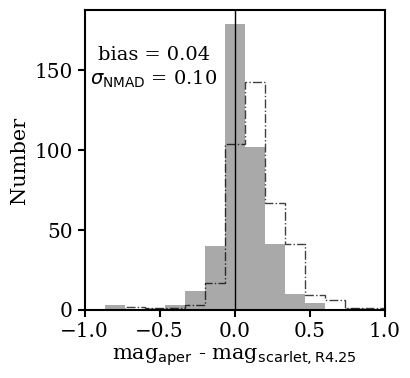

In [106]:
ax = make_subplots(ncol = 1, nrow = 1)

ax[0].hist(mag_diffs_r4,range=(-1,1),bins=15,color = "darkgrey")
ax[0].hist(mag_diffs,range=(-1,1),bins=15,color = "k",histtype = "step",ls = "-.",lw = 1,alpha=0.75)

ax[0].set_xlim([-1,1])

fs=14
ax[0].text(0.23,0.85,rf"bias = {np.median(mag_diffs_r4):.2f}",fontsize = fs,ha="center",va="center",
          transform=ax[0].transAxes )

ax[0].text(0.23,0.77,rf"$\sigma_{{\rm NMAD}}$ = {stats.median_abs_deviation(mag_diffs_r4, scale = 'normal'):.2f}",fontsize = fs,ha="center",va="center",
          transform=ax[0].transAxes )

ax[0].axvline(x = 0,color = "k",lw = 1)
ax[0].set_xlabel(r"mag$_{\rm aper}$ - mag$_{\rm scarlet, R4.25}$",fontsize = 15)
ax[0].set_ylabel(r"Number",fontsize = 15)

plt.savefig("/global/homes/v/virajvm/galaxy_image_prior/paper_1/plots/scarlet_aper_compare.pdf",bbox_inches="tight")
plt.show()

In [132]:
np.median(mag_diffs)

0.1211054069112194

In [107]:
models_to_plot = [27, 91, 104, 89, 106, 37, 82, 35, 105, 157, 62, 48, 42, 
40, 14, 139, 15, 142, 107, 74, 66, 90, 26, 13, 80, 52, 5, 119, 
24, 31, 133, 136, 39, 108, 155, 17, 92, 69]

In [130]:

def plot_f(index, data_scarlet):

    ra = data_scarlet["RA"][index]
    dec = data_scarlet["DEC"][index]
    
    file_path = data_scarlet["FILE_PATH"][index]
    img_path = data_scarlet["IMAGE_PATH"][index]


    img_data_total = fits.open(img_path)[0].data
    
    print(file_path)
    
    scar_mags = np.load( file_path + "/scarlet_mags_R4.npy")

    #get the dwarf only model with scarlet
    scarlet_total_model = np.load(file_path + "/total_model_rgb.npy")
    scarlet_model_rgb = np.load(file_path + "/dwarf_model_rgb.npy")
    scarlet_resid_rgb = np.load(file_path + "/model_residual_rgb.npy")
    bounding_box_coords = np.load(file_path + "/bounding_box_coords.npy")
    
    ##### PREPARING THE ACTUAL IMAGES!
    img_data = img_data_total[:, bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
    img_rgb = sdss_rgb([img_data[0],img_data[1],img_data[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

    ## load the dwarf only model with tractor!!
    
    tractor_bkg_model = np.load(file_path + "/tractor_background_model.npy")
    
    tractor_source_model = np.load(file_path + "/tractor_source_model.npy")
    tractor_source_model = tractor_source_model[ :, bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
    
    tractor_blend_model = np.load(file_path + "/tractor_blend_remove_model.npy")
    
    tractor_dwarf_model = img_data_total - tractor_bkg_model - tractor_blend_model
    tractor_dwarf_model = tractor_dwarf_model[ :, bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
    #apply the aperture mask
    aper_cog_mask = np.load(file_path + "/final_mask_cog.npy")
    aper_cog_mask = aper_cog_mask[bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
    
    tractor_dwarf_model[:, aper_cog_mask] = 0
    tractor_dwarf_model_rgb = sdss_rgb([tractor_dwarf_model[0],tractor_dwarf_model[1],tractor_dwarf_model[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

    desi_fiber_pos = np.load(file_path + "/fiber_pix_pos_org.npy")
    #we need to update this 

    desi_fiber_pos = desi_fiber_pos - np.array([bounding_box_coords[0] , bounding_box_coords[2]] )
    
    fig,ax = make_subplots(ncol = 1, nrow = 5, return_fig = True,row_spacing = 0.)

    # ax[3].set_title(index,fontsize = 15)
    ax[4].imshow(img_rgb,origin="lower",zorder = 0)

    radius_in_pixels = (1.5/2)/0.262 #radius of DESI fiber diameter
    circle = patches.Circle( (desi_fiber_pos[1], desi_fiber_pos[0]),radius_in_pixels, color='r', fill=False, linewidth=1.5,ls ="--")
    ax[4].add_patch(circle)
    
    fs = 17


    if index in [27, 91, 104, 89]:
        ax[0].set_ylabel(r"Scarlet Residuals",fontsize = fs)
        ax[1].set_ylabel(r"Scarlet Model",fontsize = fs)
        ax[2].set_ylabel(r"Our Reconstruction",fontsize = fs)
        ax[3].set_ylabel(r"DESI Source Model",fontsize = fs)
        ax[4].set_ylabel(r"$grz$ image",fontsize = fs)
            
    ax[4].text(0.5, 0.95,f"({ra:.3f}, {dec:.3f})",color = "white",fontsize = 17,
                 transform=ax[4].transAxes, ha = "center", verticalalignment='top')
    
    fst = 15

    ax[3].text(
    0.5, 0.925,
    rf"$\mathrm{{mag_{{DR9}}}}$: ({data_scarlet['MAG_G'][index]:.1f}, "
    rf"{data_scarlet['MAG_R'][index]:.1f}, "
    rf"{data_scarlet['MAG_Z'][index]:.1f})",
    ha="center", va="center",
    fontsize=fst, color="white",
    transform=ax[3].transAxes)

    
    ax[2].text(
    0.5, 0.925,
    rf"$\mathrm{{mag_{{aper}}}}$: ({data_scarlet['MAG_G_APERTURE_COG'][index]:.1f}, "
    rf"{data_scarlet['MAG_R_APERTURE_COG'][index]:.1f}, "
    rf"{data_scarlet['MAG_Z_APERTURE_COG'][index]:.1f})",
    ha="center", va="center",
    fontsize=fst, color="white",
    transform=ax[2].transAxes)

    ax[1].text(
    0.5, 0.925,
    rf"$\mathrm{{mag_{{scarlet}}}}$: ({scar_mags[0]:.1f}, "
    rf"{scar_mags[1]:.1f}, "
    rf"{scar_mags[2]:.1f})",
    ha="center", va="center",
    fontsize=fst, color="white",
    transform=ax[1].transAxes
)

    tractor_source_rgb = sdss_rgb(tractor_source_model)
    ax[3].imshow(tractor_source_rgb, origin="lower")
    ax[2].imshow(tractor_dwarf_model_rgb,origin="lower")    
    ax[1].imshow(scarlet_model_rgb,origin="lower")
    ax[0].imshow(scarlet_resid_rgb,origin="lower")

    org_size = np.shape(img_data)[1]

    for axi in ax:
        axi.set_xticks([])
        axi.set_yticks([])

        bar_frac = 15/(org_size * 0.262)

        x_start_frac = 0.07  # 7% from left
        y_start_frac = 0.07  # 7% from bottom
        
        # Draw the scale bar in axes coordinates
        axi.plot([x_start_frac, x_start_frac + bar_frac],
                [y_start_frac, y_start_frac],
                color='white', lw=1, transform=axi.transAxes)    
    
    

    plt.savefig(f"/global/homes/v/virajvm/galaxy_image_prior/paper_1/plots/scarlet_model_{index}.png",bbox_inches="tight")
    plt.close()



In [131]:
for mi in models_to_plot:
    plot_f(mi, data_scarlet_f)

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-150m005-160p000/1540m037/BGS_BRIGHT_tgid_39627696736569216
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-190p000-200p005/1939p047/BGS_BRIGHT_tgid_39627902668510595
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-150p005-160p010/1539p067/BGS_BRIGHT_tgid_39627950118668787
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-020p000-030p005/0259p045/BGS_BRIGHT_tgid_39627893835307165
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-240p005-250p010/2405p070/BGS_BRIGHT_tgid_39627957563555904
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-130m005-140p000/1338m017/BGS_BRIGHT_tgid_39627744694244896
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-180p000-190p005/1838p035/BGS_BRIGHT_tgid_39627872356275243
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-210m005-220p000/2148m020/BG

Make image of the one that fails that is very hard to capture in typical ways.
Does NSA have photometry for this object?

In [134]:
data_bgsb = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")


In [133]:
nsa_cat = Table.read("/pscratch/sd/v/virajvm/catalog/nsa_v1_0_1.fits")
# 39627824100806546

In [150]:
data_egs = data_bgsb[data_bgsb["TARGETID"] == 39627824100806546]

In [142]:
from desi_lowz_funcs import find_objects_nearby

nsa_egs = find_objects_nearby(nsa_cat, find_ra = 186.94195083006372, find_dec = 1.6002666871011568, ra="RA",dec="DEC")


# nsa_cat

In [149]:
nsa_egs

IAUNAME,SUBDIR,RA,DEC,ISDSS,INED,ISIXDF,IALFALFA,IZCAT,ITWODF,MAG,Z,ZSRC,SIZE,RUN,CAMCOL,FIELD,RERUN,XPOS,YPOS,NSAID,ZDIST,SERSIC_NMGY,SERSIC_NMGY_IVAR,SERSIC_OK,SERSIC_RNMGY,SERSIC_ABSMAG,SERSIC_AMIVAR,EXTINCTION,SERSIC_KCORRECT,SERSIC_KCOEFF,SERSIC_MTOL,SERSIC_B300,SERSIC_B1000,SERSIC_METS,SERSIC_MASS,XCEN,YCEN,NPROF,PROFMEAN,PROFMEAN_IVAR,QSTOKES,USTOKES,BASTOKES,PHISTOKES,PETRO_FLUX,PETRO_FLUX_IVAR,FIBER_FLUX,FIBER_FLUX_IVAR,PETRO_BA50,PETRO_PHI50,PETRO_BA90,PETRO_PHI90,SERSIC_FLUX,SERSIC_FLUX_IVAR,SERSIC_N,SERSIC_BA,SERSIC_PHI,ASYMMETRY,CLUMPY,DFLAGS,AID,PID,DVERSION,PROFTHETA,PETRO_THETA,PETRO_TH50,PETRO_TH90,SERSIC_TH50,PLATE,FIBERID,MJD,RACAT,DECCAT,ZSDSSLINE,SURVEY,PROGRAMNAME,PLATEQUALITY,TILE,PLUG_RA,PLUG_DEC,ELPETRO_BA,ELPETRO_PHI,ELPETRO_FLUX_R,ELPETRO_FLUX_IVAR_R,ELPETRO_THETA_R,ELPETRO_TH50_R,ELPETRO_TH90_R,ELPETRO_THETA,ELPETRO_FLUX,ELPETRO_FLUX_IVAR,ELPETRO_TH50,ELPETRO_TH90,ELPETRO_APCORR_R,ELPETRO_APCORR,ELPETRO_APCORR_SELF,ELPETRO_NMGY,ELPETRO_NMGY_IVAR,ELPETRO_OK,ELPETRO_RNMGY,ELPETRO_ABSMAG,ELPETRO_AMIVAR,ELPETRO_KCORRECT,ELPETRO_KCOEFF,ELPETRO_MASS,ELPETRO_MTOL,ELPETRO_B300,ELPETRO_B1000,ELPETRO_METS,IN_DR7_LSS
bytes19,bytes27,float64,float64,int32,int32,int32,int32,int32,int32,float32,float32,bytes7,float32,int16,uint8,int16,bytes3,float32,float32,int32,float32,float32[7],float32[7],int16,float32[7],float32[7],float32[7],float32[7],float32[7],float32[5],float32[7],float32,float32,float32,float32,float64,float64,uint8[7],"float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]",float32[7],float32[7],float32[7],float32[7],float32,float32,float32,float32,float32[7],float32[7],float32,float32,float32,float32[7],float32[7],int32[7],int32,int32,bytes8,float32[15],float32,float32,float32,float32,int32,int16,int32,float64,float64,float32,bytes6,bytes27,bytes8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32[7],float32[7],float32[7],float32[7],float32,float32[7],float32[7],float32[7],float32[7],int16,float32[7],float32[7],float32[7],float32[7],float32[5],float32,float32[7],float32,float32,float32,float64
J122746.29+013601.0,12h/p00/J122746.29+013601.0,186.94176121638188,1.6002227774547761,-1,119481,-1,-1,-1,-1,17.0,0.0043096547,ned,0.1,1458,1,415,301,1429.0167,567.5419,628370,0.004835546,549.1134 .. 1656.2408,0.0021769793 .. 6.1846855e-05,1,402.20004 .. 1675.475,-15.15902 .. -16.35898,556.8391 .. 143.91827,0.16582054 .. 0.029583663,-0.004561617 .. -0.0032551168,3.418851e-36 .. 1.6731481e-05,2.081269e-06 .. 0.27089724,0.21352689,0.4948131,0.015196302,60983936.0,218.0,219.0,10 .. 12,0.7051046 .. 0.0,233.31192 .. 0.0,-0.0102534 .. -0.31410998,0.0009209995 .. 0.16844906,0.97962046 .. 0.47446203,87.43363 .. 75.89824,160.33595 .. 737.5898,0.92656374 .. 3.6136087e-05,1.9481797 .. 9.1102915,57.55477 .. 0.50488764,0.80865926,138.15729,0.87256676,145.20984,471.3395 .. 1672.2068,0.027092913 .. 6.969939e-05,5.451543,0.8697946,131.94849,0.3915236 .. -3.0705829,0.38646924 .. -2.4720654,0 .. 0,0,44,v2_1_14,0.22341923 .. 258.39,60.920162,27.340874,54.021763,159.75781,0,0,0,186.94291666666663,1.600277777777778,0.0,,,,0,0.0,0.0,0.87256676,145.20984,532.32654,0.00562939,63.13086,29.847254,64.59138,63.13086,163.47844 .. 1146.0114,0.86608773 .. 2.4647486e-05,31.407269 .. -9999.0,72.53905 .. -9999.0,0.9997219,1.0008564 .. 1.0,1.0006894 .. 1.0004259,190.45338 .. 1135.0695,0.019685335 .. 2.4519013e-05,1,184.14189 .. 707.1542,-14.008815 .. -15.951489,605.7195 .. 26.797798,-0.0050824857 .. -0.0004933692,2.2069074e-05 .. 7.4078057e-06,44244736.0,3.2996832e-06 .. 0.46448305,0.12464312,0.6181098,0.035502248,1.0


In [176]:
#obtaining the NSA magnitudes to compare with
nsa_petro_gflux = nsa_egs["ELPETRO_FLUX"][:,3].data
nsa_petro_rflux = nsa_egs["ELPETRO_FLUX"][:,4].data
nsa_petro_zflux = nsa_egs["ELPETRO_FLUX"][:,6].data

nsa_petro_gmag = 22.5 - 2.5*np.log10(nsa_petro_gflux.data)[0]
nsa_petro_rmag = 22.5 - 2.5*np.log10(nsa_petro_rflux.data)[0]
nsa_petro_zmag = 22.5 - 2.5*np.log10(nsa_petro_zflux.data)[0]

In [177]:
nsa_petro_gmag,nsa_petro_rmag,nsa_petro_zmag

(15.850157141685486, 15.68455457687378, 14.852027893066406)

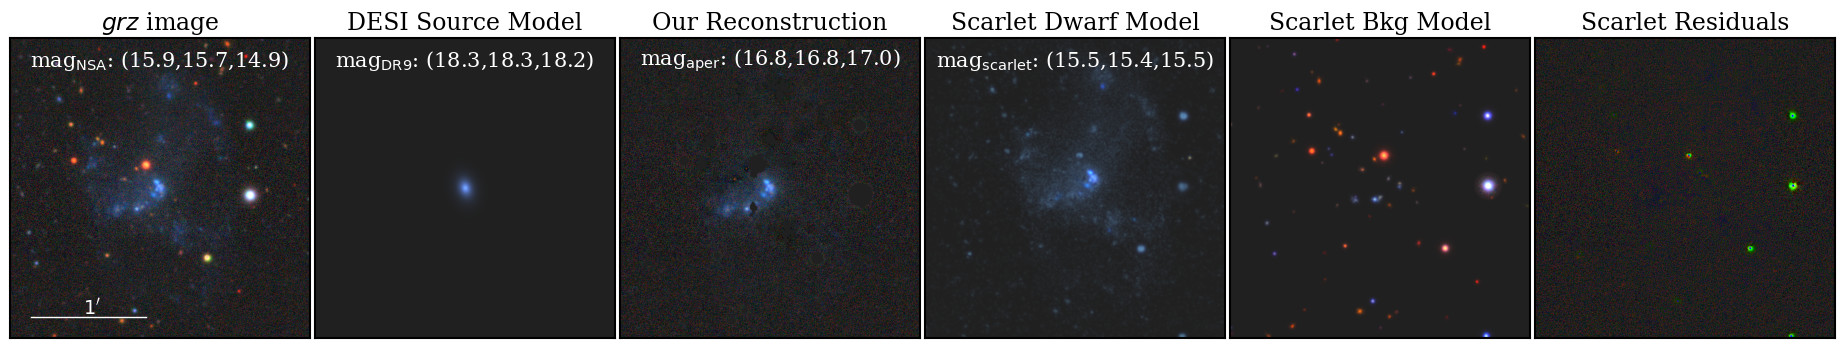

In [187]:
def cut_array(org_data, new_cutout_size = 300,invert=False):

    aper_xcen = np.shape(org_data)[1]/2
    aper_ycen = np.shape(org_data)[1]/2
    
    x_min_new = int(aper_xcen - int(new_cutout_size))
    x_max_new = int(aper_xcen + int(new_cutout_size))
    y_min_new = int(aper_ycen - int(new_cutout_size))
    y_max_new = int(aper_ycen + int(new_cutout_size))

    if invert:
        return org_data[y_min_new : y_max_new, x_min_new : x_max_new, : ]

    else:
        return org_data[:, y_min_new : y_max_new, x_min_new : x_max_new ]
    

## make a multi-panel plot of how the org grz image, include NSA photometr there, include DESI source model, 
## include our original aperture reconstruction, and then the full scarlet model of, scarlet bkg and then residuals 

file_path = data_egs["FILE_PATH"][0]

data_arr = fits.open(data_egs["IMAGE_PATH"][0])[0].data
new_cutout_size = 300
#cut the image accordingly
data_arr_cut = cut_array(data_arr, new_cutout_size)
img_rgb = sdss_rgb(data_arr_cut)

#get the desi source model
desi_source = np.load(file_path + "/tractor_source_model.npy")
desi_source_cut = cut_array(desi_source, new_cutout_size)
desi_source_rgb = sdss_rgb(desi_source_cut)

##get our original reconstruction of the dwarf!!
org_recon = np.load(file_path + "/final_reconstruct_galaxy.npy")
org_recon_cut = cut_array(org_recon, new_cutout_size)
org_recon_rgb = sdss_rgb(org_recon_cut)

##get our original reconstruction of the dwarf!!
scar_dwarf = np.load(file_path + "/dwarf_model_rgb.npy")
scar_dwarf_rgb = cut_array(scar_dwarf, new_cutout_size,invert=True)

scar_bkg = np.load(file_path + "/nondwarf_model_rgb.npy")
scar_bkg_rgb = cut_array(scar_bkg, new_cutout_size,invert=True)

scar_resid = np.load(file_path + "/model_residual_rgb.npy")
scar_resid_rgb = cut_array(scar_resid, new_cutout_size,invert=True)

ax = make_subplots(ncol = 6, nrow = 1,col_spacing = 0.05)

for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])


ax[0].imshow(img_rgb,origin="lower",rasterized=True)
ax[1].imshow(desi_source_rgb, origin="lower",rasterized=True)
ax[2].imshow(org_recon_rgb,origin="lower",rasterized=True)
ax[3].imshow(scar_dwarf_rgb,origin="lower",rasterized=True)
ax[4].imshow(scar_bkg_rgb,origin="lower",rasterized=True)
ax[5].imshow(scar_resid_rgb,origin="lower",rasterized=True)

fs = 17
ax[0].set_title("$grz$ image",fontsize = fs)
ax[1].set_title("DESI Source Model",fontsize = fs)
ax[2].set_title("Our Reconstruction",fontsize = fs)
ax[3].set_title("Scarlet Dwarf Model",fontsize = fs)
ax[4].set_title("Scarlet Bkg Model",fontsize = fs)
ax[5].set_title("Scarlet Residuals",fontsize = fs)

##include the photometry in relevant panels now 

fs= 15
ax[0].text(0.5,0.925, rf"mag$_{{\rm NSA}}$: ({nsa_petro_gmag:.1f},{nsa_petro_rmag:.1f},{nsa_petro_zmag:.1f})",
          ha="center",va="center", transform=ax[0].transAxes,color = "white",fontsize = fs)

ax[1].text(0.5,0.925, rf"mag$_{{\rm DR9}}$: ({data_egs['MAG_G'][0]:.1f},{data_egs['MAG_R'][0]:.1f},{data_egs['MAG_Z'][0]:.1f})",
          ha="center",va="center", transform=ax[1].transAxes,color = "white",fontsize = fs)


cog_mags = np.load(file_path + "/new_cog_mags.npy")
aper_gmag, aper_rmag, aper_zmag = cog_mags[0], cog_mags[1], cog_mags[2]

ax[2].text(0.5,0.925, rf"mag$_{{\rm aper}}$: ({aper_gmag:.1f},{aper_rmag:.1f},{aper_zmag:.1f})",
          ha="center",va="center", transform=ax[2].transAxes,color = "white",fontsize = fs)

scar_mags = np.load(file_path + "/scarlet_mags.npy")
scar_gmag, scar_rmag, scar_zmag = scar_mags[0], scar_mags[1], scar_mags[2]


ax[3].text(0.5,0.925, rf"mag$_{{\rm scarlet}}$: ({scar_gmag:.1f},{scar_rmag:.1f},{scar_zmag:.1f})",
          ha="center",va="center", transform=ax[3].transAxes,color = "white",fontsize = fs)


##include a bar indicating 60''
bar_frac = 60/(600 * 0.262)

x_start_frac = 0.07  # 7% from left
y_start_frac = 0.07  # 7% from bottom

ax[0].plot([x_start_frac, x_start_frac + bar_frac],
            [y_start_frac, y_start_frac],color='white', lw=1, transform=ax[0].transAxes)    
fs=14
ax[0].text( x_start_frac + 0.45*bar_frac, y_start_frac*1.1, r"$1'$",fontsize = fs,color = "white", transform=ax[0].transAxes )
    
plt.savefig("/global/homes/v/virajvm/galaxy_image_prior/paper_1/plots/very_diffuse_example.pdf",bbox_inches="tight")

plt.show()



In [188]:
nsa_egs

IAUNAME,SUBDIR,RA,DEC,ISDSS,INED,ISIXDF,IALFALFA,IZCAT,ITWODF,MAG,Z,ZSRC,SIZE,RUN,CAMCOL,FIELD,RERUN,XPOS,YPOS,NSAID,ZDIST,SERSIC_NMGY,SERSIC_NMGY_IVAR,SERSIC_OK,SERSIC_RNMGY,SERSIC_ABSMAG,SERSIC_AMIVAR,EXTINCTION,SERSIC_KCORRECT,SERSIC_KCOEFF,SERSIC_MTOL,SERSIC_B300,SERSIC_B1000,SERSIC_METS,SERSIC_MASS,XCEN,YCEN,NPROF,PROFMEAN,PROFMEAN_IVAR,QSTOKES,USTOKES,BASTOKES,PHISTOKES,PETRO_FLUX,PETRO_FLUX_IVAR,FIBER_FLUX,FIBER_FLUX_IVAR,PETRO_BA50,PETRO_PHI50,PETRO_BA90,PETRO_PHI90,SERSIC_FLUX,SERSIC_FLUX_IVAR,SERSIC_N,SERSIC_BA,SERSIC_PHI,ASYMMETRY,CLUMPY,DFLAGS,AID,PID,DVERSION,PROFTHETA,PETRO_THETA,PETRO_TH50,PETRO_TH90,SERSIC_TH50,PLATE,FIBERID,MJD,RACAT,DECCAT,ZSDSSLINE,SURVEY,PROGRAMNAME,PLATEQUALITY,TILE,PLUG_RA,PLUG_DEC,ELPETRO_BA,ELPETRO_PHI,ELPETRO_FLUX_R,ELPETRO_FLUX_IVAR_R,ELPETRO_THETA_R,ELPETRO_TH50_R,ELPETRO_TH90_R,ELPETRO_THETA,ELPETRO_FLUX,ELPETRO_FLUX_IVAR,ELPETRO_TH50,ELPETRO_TH90,ELPETRO_APCORR_R,ELPETRO_APCORR,ELPETRO_APCORR_SELF,ELPETRO_NMGY,ELPETRO_NMGY_IVAR,ELPETRO_OK,ELPETRO_RNMGY,ELPETRO_ABSMAG,ELPETRO_AMIVAR,ELPETRO_KCORRECT,ELPETRO_KCOEFF,ELPETRO_MASS,ELPETRO_MTOL,ELPETRO_B300,ELPETRO_B1000,ELPETRO_METS,IN_DR7_LSS
bytes19,bytes27,float64,float64,int32,int32,int32,int32,int32,int32,float32,float32,bytes7,float32,int16,uint8,int16,bytes3,float32,float32,int32,float32,float32[7],float32[7],int16,float32[7],float32[7],float32[7],float32[7],float32[7],float32[5],float32[7],float32,float32,float32,float32,float64,float64,uint8[7],"float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]",float32[7],float32[7],float32[7],float32[7],float32,float32,float32,float32,float32[7],float32[7],float32,float32,float32,float32[7],float32[7],int32[7],int32,int32,bytes8,float32[15],float32,float32,float32,float32,int32,int16,int32,float64,float64,float32,bytes6,bytes27,bytes8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32[7],float32[7],float32[7],float32[7],float32,float32[7],float32[7],float32[7],float32[7],int16,float32[7],float32[7],float32[7],float32[7],float32[5],float32,float32[7],float32,float32,float32,float64
J122746.29+013601.0,12h/p00/J122746.29+013601.0,186.94176121638188,1.6002227774547761,-1,119481,-1,-1,-1,-1,17.0,0.0043096547,ned,0.1,1458,1,415,301,1429.0167,567.5419,628370,0.004835546,549.1134 .. 1656.2408,0.0021769793 .. 6.1846855e-05,1,402.20004 .. 1675.475,-15.15902 .. -16.35898,556.8391 .. 143.91827,0.16582054 .. 0.029583663,-0.004561617 .. -0.0032551168,3.418851e-36 .. 1.6731481e-05,2.081269e-06 .. 0.27089724,0.21352689,0.4948131,0.015196302,60983936.0,218.0,219.0,10 .. 12,0.7051046 .. 0.0,233.31192 .. 0.0,-0.0102534 .. -0.31410998,0.0009209995 .. 0.16844906,0.97962046 .. 0.47446203,87.43363 .. 75.89824,160.33595 .. 737.5898,0.92656374 .. 3.6136087e-05,1.9481797 .. 9.1102915,57.55477 .. 0.50488764,0.80865926,138.15729,0.87256676,145.20984,471.3395 .. 1672.2068,0.027092913 .. 6.969939e-05,5.451543,0.8697946,131.94849,0.3915236 .. -3.0705829,0.38646924 .. -2.4720654,0 .. 0,0,44,v2_1_14,0.22341923 .. 258.39,60.920162,27.340874,54.021763,159.75781,0,0,0,186.94291666666663,1.600277777777778,0.0,,,,0,0.0,0.0,0.87256676,145.20984,532.32654,0.00562939,63.13086,29.847254,64.59138,63.13086,163.47844 .. 1146.0114,0.86608773 .. 2.4647486e-05,31.407269 .. -9999.0,72.53905 .. -9999.0,0.9997219,1.0008564 .. 1.0,1.0006894 .. 1.0004259,190.45338 .. 1135.0695,0.019685335 .. 2.4519013e-05,1,184.14189 .. 707.1542,-14.008815 .. -15.951489,605.7195 .. 26.797798,-0.0050824857 .. -0.0004933692,2.2069074e-05 .. 7.4078057e-06,44244736.0,3.2996832e-06 .. 0.46448305,0.12464312,0.6181098,0.035502248,1.0


In [189]:
data_egs

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,RA,DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FIBERFLUX_R,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MIN_MJD,MAX_MJD,MEAN_MJD,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY,DESINAME,FLUX_G,FLUX_IVAR_G,MAG_G,MAG_G_ERR,FLUX_R,FLUX_IVAR_R,MAG_R,MAG_R_ERR,FLUX_Z,FLUX_IVAR_Z,MAG_Z,MAG_Z_ERR,FIBERMAG_R,OBJID,SIGMA_G,FRACFLUX_G,RCHISQ_G,SIGMA_GOOD_G,SIGMA_R,FRACFLUX_R,RCHISQ_R,SIGMA_GOOD_R,SIGMA_Z,FRACFLUX_Z,RCHISQ_Z,SIGMA_GOOD_Z,SHAPE_R,SHAPE_R_ERR,MU_R,MU_R_ERR,SERSIC,SERSIC_IVAR,BA,TYPE,PHI,NOBS_G,NOBS_R,NOBS_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,HALPHA_FLUX_CG,HALPHA_FLUXERR_CG,HALPHA_EW_CG,HALPHA_EWERR_CG,MASS_CG,MASSERR_CG,LOGM_SAGA,LOGM_M24,SWEEP,is_south,STARFDIST,STARDIST_DEG,STARMAG,STAR_RADIUS_ARCSEC,STAR_RA,STAR_DEC,IMAGE_SIZE_PIX,SAMPLE,SGA_ID_MATCH,SGA_D26_NORM_DIST,SGA_DIST_DEG,IMAGE_PATH,FILE_PATH,PCNN_FRAGMENT,NEAREST_STAR_NORM_DIST,NEAREST_STAR_MAX_MAG,MAG_G_APERTURE_R375,MAG_R_APERTURE_R375,MAG_Z_APERTURE_R375,SAVE_PATH,APER_SOURCE_ON_SEGMENT,IMAGE_FITS_PATH,APER_R35_MASK_PIX_FRAC,IMAGE_MASK_PIX_FRAC,LOGM_SAGA_APERTURE_R375,MAG_G_APERTURE_COG,MAG_R_APERTURE_COG,MAG_Z_APERTURE_COG,G_APERTURE_COG_CHI2,R_APERTURE_COG_CHI2,Z_APERTURE_COG_CHI2,G_APERTURE_COG_DOF,R_APERTURE_COG_DOF,Z_APERTURE_COG_DOF,MAG_G_APERTURE_R4,MAG_R_APERTURE_R4,MAG_Z_APERTURE_R4,MAG_G_APERTURE_COG_ERR,MAG_R_APERTURE_COG_ERR,MAG_Z_APERTURE_COG_ERR,MAG_G_APERTURE_COG_PARAMS,MAG_R_APERTURE_COG_PARAMS,MAG_Z_APERTURE_COG_PARAMS,MAG_G_APERTURE_COG_PARAMS_ERR,MAG_R_APERTURE_COG_PARAMS_ERR,MAG_Z_APERTURE_COG_PARAMS_ERR,COG_DECREASE_MAX_LEN,COG_DECREASE_MAX_MAG,COG_MAXAPER_FRAC_IN,COG_APER_CEN_RA,COG_APER_CEN_DEC,COG_APER_CEN_XPIX,COG_APER_CEN_YPIX,COG_APER_PARAMS,LOGM_SAGA_APERTURE_COG,SHRED_MASKBIT
,,,,,,,,,,,,,,,,deg,deg,mas / yr,mas / yr,yr,,,,,,,,,,,mag,nanomaggy,,,,mag,mag,mag,mas,,,,,,,,,,,,,,,,,,,,,deg,deg,,s,,,mm,mm,mm,mm,,deg,arcsec,deg,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,,nanomaggy,,,,nanomaggy,,,,nanomaggy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,fl